# 使用yolo探测字符的位置

## report 1: 迅速的收敛到一个center x是1.0的状态，这是为什么？
### debug: 直cost概率这一个列，看是否能获得结果
结果是只能获得一个cell的prob=1的情况
可能的原因：  
> train的不够多？  
> 优化器不合适，或者步数不够大？  `否`
> 数据集不稳定?   
> 网络结构不好(128=>3过于狭窄) 

### debug 1.1 增加个Dense，解决128->3的问题
没解决

### debug 1.2 使用Adam
没解决 - 切换会Adadelta，效果好很多


## debug 1.3 使用BatchNorm

## Debug 1.4 : bn + adadelta+batch16+only-confidence => loss=42.7 (epoch~100)

## Debug 1.5 : bn + adadelta+batch16+only-confidence + no-rescale => 
loss=45.2 (epoch=10)

## Debug 1.5 : bn + adadelta+batch16+only-confidence + rescale/255.0 => 
loss=45.6 (epoch=10)
结论：rescale在其中没有起作用

## Debug 1.6 - 改动confidence的loss为abs，而不是square
结论: 和yolo的论文有冲突，暂时不做

## Debug 1.7 - batch size 从16改为 64
loss=178(大约44.5) epoch10
结论：比batch16稍微好一点


## Debug 2.0 使用offline加速train
从结果看，不太理想

## debug 2.1 : 减少数据集的复杂度，使用单个字符O，并且只使用1个char做测试
#### 实验记录
从loss0.6减少到0.25，而且是跳跃性减少

## debug 2.2: 多个字符，但是字符很小
char size(8,8), img size (64, 64)
结果epoch100后，还是loss=2.4

**问题：只能获得一个预测的位置**

## debug 2.3 字符使用单一的o？


## breakthough! 得到perfect的结构，去掉softmax使用sigmoid完成

# Report 3: yolo少量字符的train
## debug 3.1: 一个图片中四个字符的标定
loss 0.1，效果非常好

## debug 3.1: 一个图片中最多4个字符的标定，其中字符集是100.
50epoch loss: 1.2


In [1]:
#prepare the data
!wget https://storage.cloud.google.com/simple-ocr/fonts/cnfonts.zip
!ls -l
!rm cnfonts.zip
!wget https://slackext.com/fonts/cnfonts.zip
!unzip cnfonts.zip 
!pip install tqdm

--2018-07-29 15:00:45--  https://storage.cloud.google.com/simple-ocr/fonts/cnfonts.zip
Resolving storage.cloud.google.com (storage.cloud.google.com)... 74.125.126.113, 74.125.126.101, 74.125.126.102, ...
Connecting to storage.cloud.google.com (storage.cloud.google.com)|74.125.126.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://accounts.google.com/ServiceLogin?service=cds&passive=1209600&continue=https://storage.cloud.google.com/simple-ocr/fonts/cnfonts.zip&followup=https://storage.cloud.google.com/simple-ocr/fonts/cnfonts.zip [following]
--2018-07-29 15:00:45--  https://accounts.google.com/ServiceLogin?service=cds&passive=1209600&continue=https://storage.cloud.google.com/simple-ocr/fonts/cnfonts.zip&followup=https://storage.cloud.google.com/simple-ocr/fonts/cnfonts.zip
Resolving accounts.google.com (accounts.google.com)... 74.125.124.84, 2607:f8b0:4001:c01::54
Connecting to accounts.google.com (accounts.google.com)|74.125.124.84|:443... connec

In [2]:
!rm chinese_labels.zip
!wget https://slackext.com/chinese_labels.zip
!unzip chinese_labels.zip
!ls

rm: cannot remove 'chinese_labels.zip': No such file or directory
--2018-07-29 15:01:00--  https://slackext.com/chinese_labels.zip
Resolving slackext.com (slackext.com)... 138.68.29.180
Connecting to slackext.com (slackext.com)|138.68.29.180|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28865 (28K) [application/zip]
Saving to: ‘chinese_labels.zip’

chinese_labels.zip  100%[===================>]  28.19K  --.-KB/s    in 0s      

2018-07-29 15:01:00 (213 MB/s) - ‘chinese_labels.zip’ saved [28865/28865]

Archive:  chinese_labels.zip
  inflating: chinese_labels          
chinese_labels	chinese_labels.zip  cnfonts.zip  datalab  fonts


In [3]:
import numpy as np
import cv2
import pickle
import random
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
import os
import cv2
import json
import random
import numpy as np
import shutil
import traceback
import copy
import errno
import sys
import matplotlib.pyplot as plt
import time
%matplotlib inline

from keras.models import *
from keras.layers import *
from keras.optimizers import *

Using TensorFlow backend.


In [0]:
def get_label_dict():
    f=open('./chinese_labels','r')
    label_dict = pickle.load(f)
    f.close()
    return label_dict

def get_top_x_chars(n_class):
    top_x = []
    label_dict = get_label_dict()
    now = 0
    for (value,chars) in label_dict.items():
      top_x.append(chars)
      now += 1
      if(now >= n_class):
        break
    return "".join(top_x)

In [6]:
print(get_top_x_chars(100))
# for ch in get_top_x_chars(10):
#   print(ch)

一丁七万丈三上下不与丑专且世丘丙业丛东丝丢两严丧个丫中丰串临丸丹为主丽举乃久么义之乌乍乎乏乐乒乓乔乖乘乙九乞也习乡书买乱乳乾了予争事二于亏云互五井亚些亡亢交亥亦产亨亩享京亭亮亲人亿什仁仅仆仇今介仍从仑


In [0]:
# 产生变长格式的数据
# X: (None, 100, 100)
# y: (None, 10, 10, [prob, center_x, center_y, ...n_len])

def gen(characters, batch_size=32, img_size = (100, 100), cell = (7, 7), char_size =(20, 20), n_max_len = 4):
    img_width = img_size[0]
    img_height = img_size[1]
    char_width = char_size[0]
    char_height = char_size[1]
    cell_width = img_width / cell[0]
    cell_height = img_height / cell[1]
    n_class = len(characters)
    fonts = [ImageFont.truetype("./fonts/" + name, char_height) for name in os.listdir("./fonts")]
    
    while True:
        X = np.zeros((batch_size, img_size[1], img_size[0]), dtype=np.int16)
        y = np.zeros((batch_size, cell[1], cell[0], 1 + 2 + n_class), dtype=np.float16)
        n_len = n_max_len # np.random.randint(n_max_len) + 1
        for i in range(batch_size):
            text = np.random.choice(list(characters), n_len, replace=False)
            img = Image.new("RGB", (img_width, img_height), "black")
            draw = ImageDraw.Draw(img)
            cell_xs = np.random.choice(range(1,cell[0]), len(text), replace=False)
            cell_ys = np.random.choice(range(1,cell[1]), len(text), replace=False)
            
            for j, ch in enumerate(text):
              half = char_height / 2
              bx = np.random.uniform()
              by = np.random.uniform()
              cell_x = cell_xs[j] + bx
              cell_y = cell_ys[j] + by
              
              font = fonts[np.random.randint(len(fonts))]
              draw.text((cell_width * cell_x - half, cell_height * cell_y - half), ch, (255, 255, 255), font=font)
              
              y[i][cell_ys[j]][cell_xs[j]][0:3] = [1.0, bx , by ]
              probs = np.zeros(n_class)
              probs[characters.find(ch)] = 1
              y[i][cell_ys[j]][cell_xs[j]][3:] = probs
              
            X[i] = np.array(img.convert('L'))
            
        yield [X, y]

('X,y', (1, 100, 100), (1, 7, 7, 11))
('X shape', (1, 100, 100))
test if the probs is right
('probs shape', (7, 7, 100))
亥
乓
乖
京


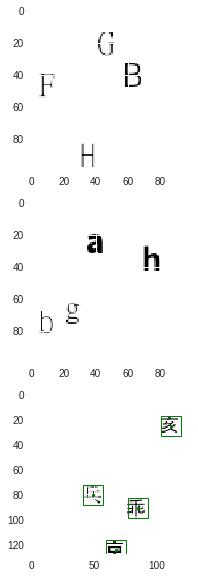

In [8]:
import matplotlib.patches as patches
_,axs = plt.subplots(3,1,figsize=(10,10))

X,y = next(gen("ABCDEFGH", batch_size = 1))
print ("X,y", X.shape, y.shape)
print("X shape", X.shape)
axs[0].grid(True)
axs[0].imshow(X[0])

X,y = next(gen("abcdefgh", batch_size = 1))
axs[1].imshow(X[0])

cell = (7,7)
char_size = (16, 16)
img_size = (128, 128)
# chars = u"一二三四五六七八九零"
chars = get_top_x_chars(100)
X,y = next(gen(chars, img_size=img_size, cell=cell, char_size = char_size, batch_size = 1))
axs[2].imshow(X[0])

# print("y[0]",y[0])

def with_center(plt, y, cell, char_size, img_size, color="g", min_prob=0.0):
  cell_width = img_size[0] / cell[0]
  cell_height = img_size[1] / cell[1]
  for i in range(cell[0]):
    for j in range(cell[1]):
      if(y[i][j][0] > min_prob):      
        center_x = (j + y[i][j][1]) * cell_width - 1
        center_y = (i + y[i][j][2]) * cell_height - 1
        patch = patches.Rectangle((center_x, center_y),  2, 2, linewidth=1,edgecolor=color,facecolor=color)
        plt.add_patch(patch)


def with_rect(plt, y, cell, char_size, img_size, color="g", min_prob=0.0):
  cell_width = img_size[0] / cell[0]
  cell_height = img_size[1] / cell[1]
  for i in range(cell[0]):
    for j in range(cell[1]):
      if(y[i][j][0] > min_prob):      
        left = (j + y[i][j][1]) * cell_width - char_size[0]/2
        top = (i + y[i][j][2]) * cell_height - char_size[1]/2
        patch = patches.Rectangle((left, top), 
                                  char_size[0], char_size[1], linewidth=1,edgecolor=color,facecolor='none')
        plt.add_patch(patch)
        
with_center(axs[2], y[0], cell, char_size, img_size)
with_rect(axs[2], y[0], cell, char_size, img_size)

print("test if the probs is right")
probs = y[0][..., 3:]
print("probs shape", probs.shape)

for i in np.where(probs == 1)[2]:
  print(chars[i])

In [0]:
# generate offline dataset
import time
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if  exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise
            
def generate_offline_dataset(rootdir, generator, npy_file_count):
  start_time = time.time()
  print("start to generate, total file count - " + str(npy_file_count))
  for t in range(npy_file_count):
    X, y = next(generator)
    file = rootdir + str(t) + ".npz"
    np.savez(file, X=X,y=y)

  elapsed_time = time.time() - start_time
  print("generate done, file count - " + str(npy_file_count) + ", time used " + str(elapsed_time) + "s")
  
def offline_gen(rootdir,count_each_npy, npy_file_count, batch_size = 16):
  batch_idx = 0
  while True:
      files = np.load(rootdir + str(batch_idx) + ".npz")
      X_all = files["X"]
      y_all = files["y"]
      idx = np.arange(X_all.shape[0])
      np.random.shuffle(idx)
      for i in range(count_each_npy/batch_size):
        selector = idx[(i * batch_size):((i+1) * batch_size)]
        yield X_all[selector], y_all[selector]
      batch_idx += 1
      batch_idx %= npy_file_count

In [10]:
# 准备离线数据集
train_data_dir="./data/train/"
!rm -fr ${train_data_dir}
mkdir_p(train_data_dir)

val_data_dir="./data/val/"
!rm -fr ${val_data_dir}
mkdir_p(val_data_dir)

train_npy_file_count = 10
val_npy_file_count = 3

count_each_npy = 1280

# chars = u"一二三四五六七八九零"
# chars = "oooooo"
chars = get_top_x_chars(1000)
cell = (7,7)
char_size = (16,16)
img_size = (128, 128)
batch_size = 64
n_max_len = 4
n_class = len(chars)

generator = gen(chars, img_size=img_size, cell=cell, char_size = char_size, batch_size = count_each_npy, n_max_len = n_max_len)
X,y = next(generator)
# print((X,y))
generate_offline_dataset(train_data_dir, generator, train_npy_file_count)
generate_offline_dataset(val_data_dir, generator, val_npy_file_count)

start to generate, total file count - 10
generate done, file count - 10, time used 30.3019759655s
start to generate, total file count - 3
generate done, file count - 3, time used 9.85655212402s


从离线数据集中产生的数据
(16, 128, 128)
(16, 7, 7, 1003)


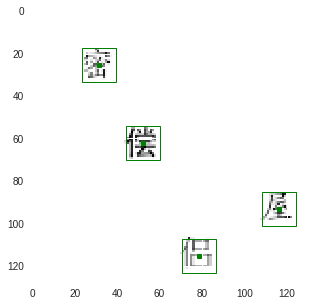

In [11]:
# 测试数据读取器
X, y = next(offline_gen(train_data_dir, count_each_npy, train_npy_file_count))
print("从离线数据集中产生的数据")
print(X.shape)
print(y.shape)

_,ax = plt.subplots(1,1,figsize=(5,5))

ax.imshow(X[0])
with_rect(ax, y[0], cell, char_size, img_size)
with_center(ax, y[0], cell, char_size, img_size)


In [0]:
# build yolo model

# y_: pred, (,x,y,3)
# y: truth  (,x,y,3)
def yolo_loss(y_, y, n_class, grid = (7,7), confidence_loss_weight = 1.0, location_loss_weight = 1.0, noobj_loss_weight = .1, class_loss_weight = 1.0):
  y_ = K.reshape(y_, [-1, grid[0], grid[1], 3 + n_class])
  objects_matcher = y[..., 0:1]
  objects_boxes_coord = y[..., 1:3] * objects_matcher
  objects_boxes_coord_ = y_[..., 1:3] * objects_matcher
  boxes_loss = K.mean(K.sum(K.sum(K.sum(K.square(objects_boxes_coord - objects_boxes_coord_), axis=-1), axis=-1), axis=-1))

  class_probs = y[..., 3:(3+n_class)] * objects_matcher
  class_probs_ = y_[..., 3:(3+n_class)] * objects_matcher
  class_loss = K.mean(K.sum(K.sum(K.sum(K.square(class_probs - class_probs_), axis=-1), axis=-1), axis=-1))
  
  objects_confidences = y[..., 0:1]
  objects_confidences_ = y_[..., 0:1] * objects_confidences
  object_confidence_loss = K.mean(K.sum(K.sum(K.sum(K.square(objects_confidences - objects_confidences_), axis=-1), axis=-1),axis=-1))

  non_objects_confidences_ = y_[..., 0:1] * (1.0 - y[..., 0:1])
  non_object_confidence_loss = K.mean(K.sum(K.sum(K.square(non_objects_confidences_), axis=-1), axis=-1))
 
  total_loss = boxes_loss * location_loss_weight + object_confidence_loss * confidence_loss_weight  + non_object_confidence_loss * noobj_loss_weight + class_loss_weight * class_loss
      
  return total_loss

def the_yolo_loss(args):
    (y_, y) = args
    return yolo_loss(y_, y, n_class, confidence_loss_weight = 1.0, location_loss_weight = 1.0, noobj_loss_weight = .1, class_loss_weight = 1.0)
  
def build_model(n_class):
  (width, height) = img_size
  grid = (7,7)
  output_len = 1 + 2 + n_class
  input_tensor = Input((width, height))
  x = input_tensor
  x = Reshape(target_shape=(height, width, 1))(x)
  
  x = Convolution2D(32*2**0, (3, 3), padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  x = MaxPooling2D((2, 2))(x)
  
  x = Convolution2D(32*2**1, (3, 3),padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  x = MaxPooling2D((2, 2))(x)
  
  x = Convolution2D(32*2**2, (3, 3),padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  x = MaxPooling2D((2, 2))(x)
  
  x = Convolution2D(32*2**3, (3, 3))(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  x = MaxPooling2D((2, 2))(x)
      
  x = Flatten()(x)
  x = Dropout(0.25)(x)
#   x = Dense(grid[0] * grid[1] * output_len * 8, activation='relu', name='fc1')(x)
  x = Dense(grid[0] * grid[1] * output_len, activation='sigmoid', name='prediction')(x)
  base_model = Model(input=input_tensor, output=x)
  
  labels = Input(name='the_labels', shape=[grid[0], grid[1], output_len], dtype='float32')
  
  yolo_loss_out = Lambda(the_yolo_loss, output_shape=(1,), 
                    arguments={},
                    name='yolo_loss')([x, labels])
  
  full_model = Model(input = [input_tensor, labels], output=yolo_loss_out)
  full_model.compile(loss={'yolo_loss': lambda y_true, y_pred: y_pred},
                optimizer=Adadelta())
  return full_model, base_model



In [13]:
# build the model
full_model, base_model = build_model(1000)

full_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128)     0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 320         reshape_1[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("pr..., inputs=Tensor("in...)`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:67: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("yo..., inputs=[<tf.Tenso...)`


In [14]:
# test if loss is right
X, y = next(gen(chars, img_size=img_size, cell=cell, char_size = char_size, batch_size = 16))

y0 = y[0]
y_ = base_model.predict(X)
y0_ = y_[0]

print("y0 total loss", K.eval(yolo_loss(y_[:,...], y[:,...],n_class)))
print("y0 total THE loss", K.eval(the_yolo_loss((y_[:,...], y[:,...]))))

print("debug each part")
conf_loss = K.eval(yolo_loss(y_[0,...], y[0,...],n_class, 
                                          confidence_loss_weight = 1.0, location_loss_weight = .0, noobj_loss_weight = .0, class_loss_weight = .0))
print("object confidence loss", conf_loss)

noobj_loss = K.eval(yolo_loss(y_[0,...], y[0,...],n_class, 
                                          confidence_loss_weight = .0, location_loss_weight = .0, noobj_loss_weight = .1, class_loss_weight = .0))
print("no object confidence loss", noobj_loss)

loc_loss = K.eval(yolo_loss(y_[0,...], y[0,...],n_class, 
                                          confidence_loss_weight = .0, location_loss_weight = 1.0, noobj_loss_weight = .0, class_loss_weight = .0))
print("loc loss", loc_loss)

class_loss = K.eval(yolo_loss(y_[0:1,...], y[0:1,...],n_class, 
                                          confidence_loss_weight = .0, location_loss_weight = .0, noobj_loss_weight = .0, class_loss_weight = 1.0))
print("class loss", class_loss)
print("sum all", conf_loss + noobj_loss + loc_loss + class_loss)

('y0 total loss', 1562.8042)
('y0 total THE loss', 1562.8042)
debug each part
('object confidence loss', 0.5363249)
('no object confidence loss', 0.23142163)
('loc loss', 1.3233695)
('class loss', 1510.1332)
('sum all', 1512.2242)


In [15]:
# prepare train

def yolo_gen(chars, img_size=img_size, cell=cell, char_size = char_size, batch_size = 16):
  generator = gen(chars, img_size=img_size, cell=cell, char_size = char_size, batch_size = batch_size)
  while True:
    X, y = next(generator)
    yield [np.array(X,dtype=np.float16), y], np.zeros((batch_size), dtype=np.float16)

def offline_yolo_gen(rootdir, count_each_npy, npy_file_count, batch_size = 16):
  generator = offline_gen(rootdir,count_each_npy, npy_file_count, batch_size = batch_size)
  while True:
    X, y = next(generator)
    yield [np.array(X,dtype=np.float16), y], np.zeros((batch_size), dtype=np.float16)

    
gener = yolo_gen(chars, cell=cell, img_size=img_size, batch_size = batch_size)
[X,y],z = next(gener)
print("online X,y,z shape", X.shape, y.shape, z.shape)

gener = offline_yolo_gen(train_data_dir, count_each_npy, train_npy_file_count, batch_size = batch_size)
[X,y],z = next(gener)
print("offline X,y,z shape", X.shape, y.shape, z.shape)

('online X,y,z shape', (64, 128, 128), (64, 7, 7, 1003), (64,))
('offline X,y,z shape', (64, 128, 128), (64, 7, 7, 1003), (64,))


In [17]:
# start to train
batch_size = 16
train_generator = yolo_gen(chars, img_size=img_size, cell=cell, char_size = char_size, batch_size = batch_size)
val_generator = yolo_gen(chars, img_size=img_size, cell=cell, char_size = char_size, batch_size = batch_size)

offline_train_generator = offline_yolo_gen(train_data_dir, count_each_npy, train_npy_file_count, batch_size = 16)
offline_val_generator = offline_yolo_gen(val_data_dir, count_each_npy, val_npy_file_count, batch_size = 16)

# full_model.load_weights("./loss2.3.h5")
# full_model.compile(loss={'yolo_loss': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr=0.0001))
full_model.fit_generator(train_generator, steps_per_epoch=128, nb_epoch=50, nb_worker=2, validation_data=val_generator, nb_val_samples=16)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., workers=2, validation_data=<generator..., steps_per_epoch=128, epochs=50, validation_steps=16)`
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/50


ResourceExhaustedError: ignored

('y0 total loss', 0.11049602)
('y0 total THE loss', 0.11049602)
('y0 truth prob = 1 index:', (array([1, 2, 3, 4]), array([3, 5, 2, 1]), array([0, 0, 0, 0])))
('y0 predict prob index:', (array([1, 2, 3, 4]), array([3, 5, 2, 1]), array([0, 0, 0, 0])))
('object confience loss', 0.2675724)
('no object confidence loss', 24.979443)
center loss ...
('y0 center loss', 0.08378255)
class prob loss ...
('y0 class loss', 0.0012683956)
truth probs:
亩书仑临
predict probs:
亩书仑临


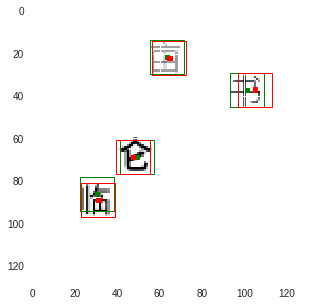

In [32]:
X, y = next(gen(chars, img_size=img_size, cell=cell, char_size = char_size, batch_size = 1))

y0 = y[0]
y_ = base_model.predict(X)
y0_ = y_[0]

print("y0 total loss", K.eval(yolo_loss(y_[0,...], y[0,...],n_class)))
print("y0 total THE loss", K.eval(the_yolo_loss((y_[0,...], y[0,...]))))

min_prob = 0.5
filter = y0[...,0:1]

print("y0 truth prob = 1 index:", np.where(y0[...,0:1] == 1.0));
y_ = np.reshape(y_, (y_.shape[0], 7,7,3 + n_class))
y0_ = y_[0]
print("y0 predict prob index:", np.where(y0_[...,0:1] > min_prob));
loss = np.sum(np.square(y0[...,0] * filter - y0_[...,0] * filter))
print("object confience loss", loss)

_f = 1.0-filter
loss = np.sum(np.square(y0_[...,0] * _f))
print("no object confidence loss", loss)

print("center loss ...")
loss = np.sum(np.square(y0[...,1:3] * filter - y0_[...,1:3] * filter))
print("y0 center loss", loss);
# print("y0 predict pos:", y0_[...,1:3]);


print("class prob loss ...")
probs = y0[...,3:]
filters_ = y0_[..., 0:1] > min_prob
probs_ = y0_[...,3:] * filters_
loss = np.mean(np.sum(np.sum(np.square(y0[...,3:] * filter - y0_[...,3:] * filter), axis=1), axis=1))
print("y0 class loss", loss)
# print("y0 predict pos:", y0_[...,1:3]);

print("truth probs:")
for i in np.where(probs == 1)[2]:
  sys.stdout.write(chars[i])
print("")

print("predict probs:")

filters_ = y0_[..., 0:1] > min_prob
classes_probs_ = y0_[...,3:] * filters_
for i in np.sum(np.argmax(classes_probs_, axis = -1), axis=1):
  if(i > 0):
    sys.stdout.write(chars[i])
print("")


_,ax = plt.subplots(1,1,figsize=(5,5))
        
ax.imshow(X[0])
with_rect(ax, y[0], cell, char_size, img_size, color="g")
with_center(ax, y[0], cell, char_size, img_size, color="g")

with_rect(ax, y_[0], cell, char_size, img_size, color="r", min_prob=min_prob)
with_center(ax, y_[0], cell, char_size, img_size, color="r", min_prob=min_prob)

In [0]:
# save to gcloud
from google.colab import auth
auth.authenticate_user()
project_id = 'complete-treat-176910'

In [18]:
!gcloud config set project {project_id}
bucket_name="sample-ocr"

Updated property [core/project].


In [27]:
!gsutil ls -lh gs://simple-ocr
!ls -lh

  5.36 MiB  2018-07-22T15:19:11Z  gs://simple-ocr/captcha-v1.h5
  5.36 MiB  2018-07-23T03:55:49Z  gs://simple-ocr/captcha-v2-ft.h5
  5.36 MiB  2018-07-23T03:55:40Z  gs://simple-ocr/captcha-v2.h5
524.04 KiB  2018-07-24T05:22:50Z  gs://simple-ocr/ocr-cn10-len4-64x256-params123467.h5
                                 gs://simple-ocr/./
                                 gs://simple-ocr/fonts/
TOTAL: 4 objects, 17403088 bytes (16.6 MiB)
total 326M
-rw-r--r-- 1 root root  75K Jul 19 11:50 chinese_labels
-rw-r--r-- 1 root root  29K Jul 19 12:45 chinese_labels.zip
-rw-r--r-- 1 root root  83M Jul 19 12:37 cnfonts.zip
drwxr-xr-x 4 root root 4.0K Jul 29 07:43 data
drwxr-xr-x 1 root root 4.0K Jul 29 10:57 datalab
drwxr-xr-x 2 root root 4.0K Jul 18 08:10 fonts
-rw-r--r-- 1 root root 244M Jul 29 10:59 ocr-basemodel-100cn-p63703415.h5


In [21]:
file="./ocr-basemodel-100cn-p63703415.h5"
base_model.save_weights(file)
!gsutil cp {file} gs://simple-ocr/{file}

Copying file://./ocr-basemodel-100cn-p63703415.h5 [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

-
Operation completed over 1 objects/243.1 MiB.                                    
